# Genetic Engineering - Findind lab of origin for various plasmids using Sequential Neural Network tuned via Bayesian Optimization.



Intro- notes <br>
Driven Data Competition
<br>
<br>
<br>
Usefullness -> allows better controle over who is doing what

Topo function pad
Topo Seq NN
Topo Bayesian opt (link to giuthub)

plot model ?

mention voigt lab (without link)



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
from sklearn.model_selection import train_test_split
#import 
df=pd.read_csv(r"C:\Users\Utilisateur\Desktop\Challenge\genetic_engineering\train_values.csv",index_col=0)
Labels=pd.read_csv(r"C:\Users\Utilisateur\Desktop\Challenge\genetic_engineering\train_labels.csv",index_col=0)

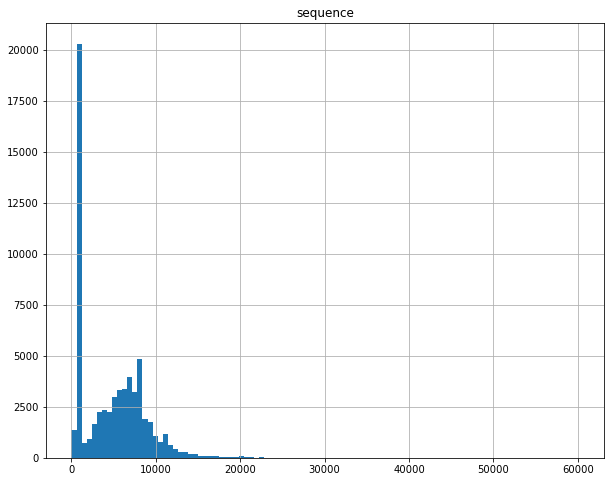

In [4]:
"""E D A """
#sequences
Seq_length=pd.DataFrame(df.sequence.apply(len))
Seq_length.hist(bins=100,figsize=(10,8))

#lab
Lab_id=pd.DataFrame(Labels.idxmax(axis=1),columns=['lab_id'])
plasmid_per_lab=pd.DataFrame(Lab_id['lab_id'].value_counts().sort_values(ascending=False))
plasmid_per_lab.columns=['plasmid_per_lab']
plasmid_per_lab['Percentage']=plasmid_per_lab/df.shape[0]

In [6]:
#split train/test
x_train, x_test, y_train, y_test = train_test_split(df, Labels, test_size=0.2, random_state=1)
#split train/val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2    

# Defining functions

### Padding function

    As the input of the neural network ought to be vectors of the same size and since the plasmid sequences range from .... to ..., median value : , we have to pas the sequences, cad, define a threshold,shorten the sequences longer than this threshold and extend  with random nucleoids the shorter ones. That is what **pad_dna** is doing


### One hot encoding

    The base pare cannot be fed as raw inputs to the network, we therefore need to transform them into 1hot vectors, following the arbitrary convention : 'A':[1,0,0,0],'T':[0,1,0,0],'G':[0,0,1,0],'C':[0,0,0,1], 'N':[0,0,0,0]} where N is ????

In [7]:
def pad_dna(seqs,maxlen):
    padded_seqs = [''] * len(seqs)
    for i in seqs:
        if len(i) > maxlen:
            i = i[:maxlen]
            maxlen = len(i)
    for j in range(len(seqs)):
        if len(seqs[j]) > maxlen:
            seq = seqs[j][0:maxlen]
        else:
            seq = seqs[j]
        padded_seqs[j] = seq + "N" * (maxlen - len(seq))
    return padded_seqs

def convert_onehot2D(list_of_seqs):
    one_hot = np.zeros((len(list_of_seqs),4,len(list_of_seqs[0])))
    nt_dict = {'A':[1,0,0,0],'T':[0,1,0,0],'G':[0,0,1,0],'C':[0,0,0,1], 'N':[0,0,0,0]}
    count = 0
    for seq in list_of_seqs:
        if len(seq) > 1:
            for letter in range(len(seq)):
                for i in range(4):
                    one_hot[count][i][letter] = (nt_dict[seq[letter]])[i]
        count += 1
    return one_hot


#encoding sequences

max_len=500
X_train_padded=pad_dna(x_train.sequence,max_len)
X_val_padded=pad_dna(x_val.sequence,max_len)
X_test_padded=pad_dna(x_test.sequence,max_len)

#steady variables
X_train=np.transpose(convert_onehot2D(X_train_padded), axes=(0,2,1))
X_val=np.transpose(convert_onehot2D(X_val_padded), axes=(0,2,1))
X_test=np.transpose(convert_onehot2D(X_test_padded), axes=(0,2,1))

Y_train=y_train
Y_val=y_val
Y_test=y_test


# Bayesian optimization

Package details on github [here](https://github.com/fmfn/BayesianOptimization)

number of iterations
parameters of iteration (number of neurones/ number of filter and length of filter.)
monitoring (as target) : validation accuracy


In [11]:
"""                  B A Y E S I A N   -  O P T I M I Z A T I O N                """
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import time
from keras.optimizers import SGD
from keras.models import load_model 

from bayes_opt import BayesianOptimization

#network parameters:
dna_bp_length=X_train.shape[1]
num_classes=Y_train.shape[1]
min_batch_size = 8

def neural_network_target(num_dense_nodes,filter_num,filter_length):
    model = Sequential()
    model.add(Convolution1D(filters=int(filter_num),
                            kernel_size=int(filter_num),
                            activation="relu"))
    model.add(MaxPooling1D(pool_size=int(max_len-filter_num+1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=num_dense_nodes))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dense(units=num_classes))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.TopKCategoricalAccuracy(10)])
    checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", monitor="val_acc", mode='auto', verbose=1, \
                  save_best_only=True)  
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, mode='auto', verbose=0)
    
    epoch=1
    history = model.fit(X_train, Y_train, batch_size = min_batch_size,
                        validation_data=(X_val, Y_val),
                        epochs=epoch, verbose=1)
    
    result=history.history['val_top_k_categorical_accuracy'][-1]

    return result


gp_params = {"alpha": 1e-5, "n_restarts_optimizer": 2}
bo = BayesianOptimization(neural_network_target,
                          {'num_dense_nodes': (4,512),
                           'filter_num': (1,500),
                           'filter_length': (1,48)})

bo.maximize(n_iter=3, acq="ucb", kappa=5, **gp_params)


print(bo.max)


|   iter    |  target   | filter... | filter... | num_de... |
-------------------------------------------------------------
4727/4727 [==============================] - 46s 10ms/step - loss: 5.5363 - top_k_categorical_accuracy: 0.3669 - val_loss: 4.8663 - val_top_k_categorical_accuracy: 0.4350
|  1        |  0.435    |  5.335    |  47.38    |  5.431    |
4727/4727 [==============================] - 71s 15ms/step - loss: 4.4017 - top_k_categorical_accuracy: 0.5280 - val_loss: 3.8178 - val_top_k_categorical_accuracy: 0.6148
|  2        |  0.6148   |  15.75    |  492.1    |  185.7    |
4727/4727 [==============================] - 198s 42ms/step - loss: 4.3757 - top_k_categorical_accuracy: 0.5354 - val_loss: 3.7899 - val_top_k_categorical_accuracy: 0.6322
|  3        |  0.6322   |  4.81     |  412.6    |  465.5    |
4727/4727 [==============================] - 143s 30ms/step - loss: 4.4219 - top_k_categorical_accuracy: 0.5268 - val_loss: 3.8115 - val_top_k_categorical_accuracy: 0.6215
|  4

# Sequential Neural Network

info : 
use conv1D with ...parameters (extracted from bayesian optimization)
batch normalization for ???
Metrics (Top 10)-> tf.keras.metrics.TopKCategoricalAccuracy(10)


In [ ]:
"""Neural Network"""""

#network parameters:
dna_bp_length=X_train.shape[1]
num_classes=Y_train.shape[1]
# network hyperparameters
filter_num = 130 
filter_len = 46
num_dense_nodes = 345 
total_epoch = 100 
min_batch_size = 8
start = time.time()

# model specification
model = Sequential()
model.add(Convolution1D(filters=filter_num,
                        kernel_size=filter_len,
                        activation="relu"))
model.add(MaxPooling1D(pool_size=max_len-filter_len+1))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=num_dense_nodes))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(units=num_classes))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(10)])
checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", monitor="val_acc", mode='auto', verbose=1, \
              save_best_only=True)  
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, mode='auto', verbose=1)

epoch=10
history = model.fit(X_train, Y_train, batch_size = min_batch_size,
                    validation_data=(X_val, Y_val),
                    epochs=epoch, verbose=1)

print(model.summary())
    
    
net=history    
#plot
loss=net.history['loss']
acc=net.history['top_k_categorical_accuracy']
val_loss=net.history['val_loss']
val_acc=net.history['val_top_k_categorical_accuracy']

plt.plot(loss,label='loss')
plt.plot(acc,label='accuracy')
plt.plot(val_loss,label='val_loss')
plt.plot(val_acc,label='val_accuracy')
plt.hlines(1,  0,epoch, colors='k', linestyles='--')
plt.legend()
plt.title('CNN')

stop = time.time()

print('computational time for nn :',stop-start,  'seconds')
